# Group 2 Capstone Project
In the dynamic realm of e-commerce, this project aims to address a critical challenge that is understanding the factors that drive customer returns, with a focus on enhancing profitability. Conventional approaches focus on maximizing sales, but our unique proposition is to unravel the complexities of dissatisfaction leading to product returns. By analyzing the feature importance within the dataset, we intend to provide actionable recommendations for businesses to minimize returns, thereby fostering relationships with customers. 

#### Import nessecary libraries

In [1]:
#! pip uninstall scikit-learn --yes
#! pip uninstall imblearn --yes
#! pip install scikit-learn==1.2.2
#! pip install imblearn

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import imblearn

### Read in dataset

Download the dataset from https://www.kaggle.com/datasets/willianoliveiragibin/websites-e-comerce and place it in the folder with this notebook.

The raw dataset has 172838 entries with 15 columns that include: 'accessed_date', 'duration_(secs)', 'network_protocol', 'ip', 'bytes', 'accessed_Ffom', 'age', 'gender', 'country', 'membership', 'language','sales', 'returned_amount', 'pay_method' with target variable being 'returned'. This dataset was taken from the time frame of a week.

In [3]:
#read
df = pd.read_csv("E-commerce Website Logs new.csv")
df.head()

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,accessed_date,duration_(secs),network_protocol,ip,bytes,accessed_Ffom,age,gender,country,membership,language,sales,returned,returned_amount,pay_method
0,2017-03-14 17:43:57.172,2533,TCP,1.10.195.126,20100,Chrome,28,Female,CA,Normal,English,261.96,No,0,Credit Card
1,2017-03-14 17:43:57.172,4034,TCP,1.1.217.211,20500,Mozilla Firefox,21,Male,AR,Normal,English,731.94,No,0,Debit Card
2,2017-03-14 17:43:26.135,1525,TCP,1.115.198.107,90100,Mozilla Firefox,20,Male,PL,Normal,English,14.62,No,0,Cash
3,2017-03-14 17:43:26.135,4572,TCP,1.121.152.143,100300,Mozilla Firefox,66,Female,IN,Normal,Spanish,9.575.775,No,0,Credit Card
4,2017-03-14 18:17:09.005,3652,TCP,1.123.135.213,270200,Mozilla Firefox,53,Female,KR,Normal,Spanish,22.368,No,0,Cash


The primary business problem is to help online businesses with minimizing their returns. Looking into different aspects of customers who buy and/or return items (such as age, what kind of membership they have with the company, the language they use when shopping, gender, etc.) can give useful insight on how company can utilize their marketing strategies by targeting these certain aspects of customers so that they may not return as many items that they are right now. This dataset gives information on customers who bought and/or returned items within a specific week. We thought that these features given by this dataset would give information on which customer aspects have the most effect on customers returning items.

### Data Pre-processing

First, we went into the dataset and understood what each of the columns could contribute to our buisness problem. After thoroughly looking thorugh our options, we decided to drop 'network_protocol', 'ip', 'bytes', 'sales', and 'returned_amount'. The column 'network_protocol' didn't seem like a feature that would provide any useful information to our buisness problem as it does not give insght to any kind of marketing strategy or promotions. The column 'ip' only give a unique value for each data point and that would not be very useful for a model. The column 'bytes' was not defined when we were researching our dataset, thus we were not sure what the values represented whether it be the amount of bytes the customer was using when accessing the website or when purchasing the product, etc. so we deemed it so to remove this column as well. The columns 'sales' and 'returned_amount' are types of target variables that we had the choice of using, but decided against it. Since these columns are directly related to our target variable, wherein a 0 in sales can easily predict that the item was returned and a 0 in returned amount would predict the item is not returned, it would not provide our mode with useful information, thus we removed them.

In [4]:
#start prep
df.drop(['accessed_date','duration_(secs)','network_protocol', 'ip', 'bytes', 'sales', 'returned_amount'], axis=1, inplace=True)
df.head()

,accessed_Ffom,age,gender,country,membership,language,returned,pay_method
0,Chrome,28,Female,CA,Normal,English,No,Credit Card
1,Mozilla Firefox,21,Male,AR,Normal,English,No,Debit Card
2,Mozilla Firefox,20,Male,PL,Normal,English,No,Cash
3,Mozilla Firefox,66,Female,IN,Normal,Spanish,No,Credit Card
4,Mozilla Firefox,53,Female,KR,Normal,Spanish,No,Cash


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172838 entries, 0 to 172837
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   accessed_Ffom  172838 non-null  object
 1   age            172838 non-null  object
 2   gender         172838 non-null  object
 3   country        172838 non-null  object
 4   membership     172838 non-null  object
 5   language       172838 non-null  object
 6   returned       172838 non-null  object
 7   pay_method     172838 non-null  object
dtypes: object(8)
memory usage: 10.5+ MB


We can see that there are no null values detected from our initial search of finding them. We wanted to make sure that there were no place holders within each of the columns.

Before dropping the specified columns, the dataset had 172,838 rows and 10 columns, total number of elements (size) 1,728,380. After dropping the specified columns (‘network_protocol’, ‘ip’, ‘bytes’, ‘sales’, ‘returned_amount’, the dataset has 158,095 rows and 10 columns, total number of elements (size) 1,580,950.

##### 1. Age and Gender column

When looking into the age column, we saw that there were placeholder values that represented null items. For some reason there were 2 kinds of 0s and then dashed lines. However, almost 50% of our data consists of these placeholder values which makes it difficult on deciding what to do with these values. We decided on just removing the those values as it was a way not to skew the data because replacing the mean, median, or mode in those values would just make an our model more biased to that value in the age feature. Additionally, since we still have a decent amount of data to use even after removing those data points, we will tset with the data that was left over and if the metrics point to having a better model with more data point then we may return to these data points and add them in. Furthermore, when researching with this column, we also learned that any unknown genders/ place holder values for the gender column was removed whenever we removed all the unknown ages. Since we are working with the data set without the unknown ages, we can skip identifying any unknown values in the gender column.

In [6]:
df['age'].value_counts(normalize=True)

0     0.241648
0     0.182917
--    0.085300
37    0.010247
22    0.010108
43    0.009905
51    0.009882
64    0.009876
24    0.009836
30    0.009824
40    0.009784
48    0.009732
61    0.009685
39    0.009628
27    0.009610
52    0.009604
38    0.009570
19    0.009564
28    0.009552
42    0.009518
41    0.009512
56    0.009494
67    0.009442
21    0.009442
26    0.009425
57    0.009425
62    0.009419
36    0.009408
46    0.009396
68    0.009396
33    0.009379
53    0.009350
69    0.009327
58    0.009321
25    0.009309
29    0.009298
50    0.009292
32    0.009286
34    0.009275
31    0.009263
49    0.009257
59    0.009251
66    0.009251
47    0.009234
23    0.009217
44    0.009217
63    0.009153
60    0.009124
20    0.009072
54    0.009066
45    0.009037
35    0.008985
65    0.008980
55    0.008968
18    0.008939
Name: age, dtype: float64

In [7]:
#remove non-integer values
df = df[df['age']!="--"] 

In [8]:
#turn age into integer
df['age'] = df['age'].astype('int64')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158095 entries, 0 to 172837
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   accessed_Ffom  158095 non-null  object
 1   age            158095 non-null  int64 
 2   gender         158095 non-null  object
 3   country        158095 non-null  object
 4   membership     158095 non-null  object
 5   language       158095 non-null  object
 6   returned       158095 non-null  object
 7   pay_method     158095 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.9+ MB


In [10]:
df['age'].value_counts(normalize=True)

0     0.464158
37    0.011202
22    0.011050
43    0.010829
51    0.010804
64    0.010797
24    0.010753
30    0.010740
40    0.010696
48    0.010639
61    0.010589
39    0.010525
27    0.010506
52    0.010500
38    0.010462
19    0.010456
28    0.010443
42    0.010405
41    0.010399
56    0.010380
67    0.010323
21    0.010323
26    0.010304
57    0.010304
62    0.010298
36    0.010285
46    0.010272
68    0.010272
33    0.010253
53    0.010222
69    0.010196
58    0.010190
25    0.010177
29    0.010165
50    0.010158
32    0.010152
34    0.010139
31    0.010127
49    0.010120
59    0.010114
66    0.010114
47    0.010095
44    0.010076
23    0.010076
63    0.010007
60    0.009975
20    0.009918
54    0.009912
45    0.009880
35    0.009823
65    0.009817
55    0.009804
18    0.009773
Name: age, dtype: float64

In [11]:
df['gender'].value_counts()

Female     93903
Male       63049
Unknown     1143
Name: gender, dtype: int64

In [12]:
#remove placeholders
df = df[df['age']!=0]

In [13]:
df['age'].value_counts()

37    1771
22    1747
43    1712
51    1708
64    1707
24    1700
30    1698
40    1691
48    1682
61    1674
39    1664
27    1661
52    1660
38    1654
19    1653
28    1651
42    1645
41    1644
56    1641
21    1632
67    1632
26    1629
57    1629
62    1628
36    1626
68    1624
46    1624
33    1621
53    1616
69    1612
58    1611
25    1609
29    1607
50    1606
32    1605
34    1603
31    1601
49    1600
59    1599
66    1599
47    1596
44    1593
23    1593
63    1582
60    1577
20    1568
54    1567
45    1562
35    1553
65    1552
55    1550
18    1545
Name: age, dtype: int64

In [14]:
df['age'].describe()

count    84714.000000
mean        43.438263
std         14.980135
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64

In [15]:
df['gender'].value_counts()

Female    50682
Male      34032
Name: gender, dtype: int64

##### 2. Payment Method column

We have 4 payment methods; Cash, Credit Card, Debit Card, and Others. No need to deal with null, duplicates, or outliers

In [16]:
df['pay_method'].value_counts()

Cash           35625
Credit Card    25962
Debit Card     13507
Others          9620
Name: pay_method, dtype: int64

##### 3. Membership Column

When the 0s and null value Age rows were removed, the Not Logged In membership class is removed, leaving only the normal and premium classes for the model. No need to deal with null, duplicates, or outliers.

In [17]:
df['membership'].value_counts()

Premium    54847
Normal     29867
Name: membership, dtype: int64

##### 4. Language column

There are 29 different languages used on the e-commerce site. The top 3 most common were English Chinese and Spanish. The format is not consistent across our data so we will capitalize the first letter of each language to provide consistency. There are no null values to address or any outliers.

In [18]:
df['language'].value_counts()

English       49939
Chinese       10172
Spanish        7124
Russian        6013
French         3972
Italian        3359
German          955
Japanese        599
persian         400
Thai            361
Dutch           288
italian         284
Portuguese      199
Arabic          186
polish          123
mongolian       114
malayalam        95
swahili          72
nepali           71
swedish          71
norwegian        58
Slovak           48
slovene          44
urdu             39
romanian         36
malay            30
macedonian       24
serbian          14
tegulu           13
marathi          11
Name: language, dtype: int64

##### 5. Accessed_from column

There are 7 different access methods found in the database; Android App, Chrome, Mozilla Firefox, iOS App, Safari, Microsoft Edge and Others. SafFRi is a misspelling of Safari and will be fixed before modeling. There are no null values to address or any outliers.

In [19]:
df['accessed_Ffom'].value_counts()

Android App        18768
Chrome             13818
Mozilla Firefox    13015
Others             13007
IOS App            10627
Safari              8082
Microsoft Edge      7325
SafFRi                72
Name: accessed_Ffom, dtype: int64

##### 6. Country column

There are 27 countries, all displayed as country codes, that users accessed the e-commerce site from. The top 3 were Italy, United States and Canada. No need to deal with null, duplicates, or outliers

In [20]:
df['country'].value_counts()

IT    16892
US    14611
CA     8695
CN     4988
JP     4885
RU     4661
CH     4060
IN     3942
PL     3276
GB     2443
AT     2342
AU     2227
SE     2210
NO     1819
AR     1581
DE     1064
KR     1060
PR      850
CO      735
ZA      621
MX      528
PE      519
FI      323
DK      110
IE      109
AE      108
FR       55
Name: country, dtype: int64

##### 7. Target variable

The thing that needs to be addressed with the target variable is the idea of an unbalanced data set. There is only about 15% of the data that contains customers that returned an item. Therefore, we need to test with different sampling techniques (under/over) to get the dataset more balanced to have a better outcome with the metrics of modeling.

In [21]:
df['returned'].value_counts(normalize=True)

No     0.853944
Yes    0.146056
Name: returned, dtype: float64

## Duplicate Handling

In [22]:
# Combine rows with 'Safari' and 'SafFRi'
df.loc[df['accessed_Ffom'] == 'SafFRi', 'accessed_Ffom'] = 'Safari'

# Check the updated 'accessed_Ffom' column
print("Updated accessed_Ffom:")
print(df['accessed_Ffom'].value_counts())

Updated accessed_Ffom:
Android App        18768
Chrome             13818
Mozilla Firefox    13015
Others             13007
IOS App            10627
Safari              8154
Microsoft Edge      7325
Name: accessed_Ffom, dtype: int64


In [23]:
# Capitalizing the first letter of each word
df['language'] = df['language'].str.split().str[0].str.capitalize()
print(df['language'].value_counts())

English       49939
Chinese       10172
Spanish        7124
Russian        6013
French         3972
Italian        3643
German          955
Japanese        599
Persian         400
Thai            361
Dutch           288
Portuguese      199
Arabic          186
Polish          123
Mongolian       114
Malayalam        95
Swahili          72
Nepali           71
Swedish          71
Norwegian        58
Slovak           48
Slovene          44
Urdu             39
Romanian         36
Malay            30
Macedonian       24
Serbian          14
Tegulu           13
Marathi          11
Name: language, dtype: int64


## Export data for use in EDA file

In [24]:
df.to_csv('processed.csv')

## Category Encoding
We used both label encoding and one hot encoding methods on the categorical columns in the dataset. Specifically, label encoding was applied for the Gender and Returned as each of those columns had only two types of categories. One hot encoding was used for the accessed_Ffom, country, membership, language, and pay_method columns as these columns had at least 3 different types of categories. We used label encoding and one hot encoding as data pre-processing steps to convert categorical columns to numerical labels so we can implement different machine learning models that can take the encoded values as input. 

In [25]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['returned'] = le.fit_transform(df['returned'])

In [26]:
encoded_columns = ['accessed_Ffom', 'country', 'membership', 'language', 'pay_method']
ohe = pd.get_dummies(df[encoded_columns],prefix=encoded_columns, drop_first=True)
df_encoded = pd.concat([df, ohe], axis=1)
df_encoded = df_encoded.drop(encoded_columns,axis=1)

In [27]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84714 entries, 0 to 99456
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            84714 non-null  int64
 1   gender                         84714 non-null  int32
 2   returned                       84714 non-null  int32
 3   accessed_Ffom_Chrome           84714 non-null  uint8
 4   accessed_Ffom_IOS App          84714 non-null  uint8
 5   accessed_Ffom_Microsoft Edge   84714 non-null  uint8
 6   accessed_Ffom_Mozilla Firefox  84714 non-null  uint8
 7   accessed_Ffom_Others           84714 non-null  uint8
 8   accessed_Ffom_Safari           84714 non-null  uint8
 9   country_AR                     84714 non-null  uint8
 10  country_AT                     84714 non-null  uint8
 11  country_AU                     84714 non-null  uint8
 12  country_CA                     84714 non-null  uint8
 13  country_CH      

## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop(["returned"], axis=1)
y = df_encoded.returned
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=125)

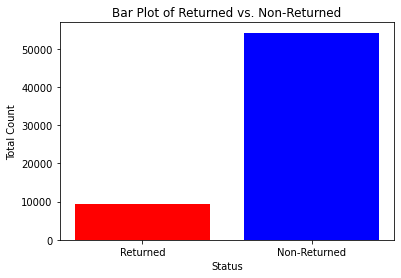

In [29]:
counts = y_train.value_counts()
counts = counts.iloc[::-1]

plt.bar(['Returned', 'Non-Returned'], counts.values, color=['red', 'blue'])

plt.xlabel('Status')
plt.ylabel('Total Count')
plt.title('Bar Plot of Returned vs. Non-Returned')

plt.show()

## Dealing with Imbalanced Data

As mentioned earlier the target variable in our dataset is imbalanced. This brings a few problems; possibility of bias toward the majority class, resulting in poor performance on the minority class, metrics such as accuracy can be misleading as high accuracy can be achieved by predicting the majority class, and the model may focus more on features that help distinguish the majority class, neglecting features important for minority class prediction.

We used Oversampling/Undersampling and SMOTE to resolve these problems.

In [30]:
print(Counter(y))

Counter({0: 72341, 1: 12373})


#### Oversampling

Oversampling duplicates the minority class until there are an equal number of records in the minority class as majority class

Counter({0: 54243, 1: 54243})


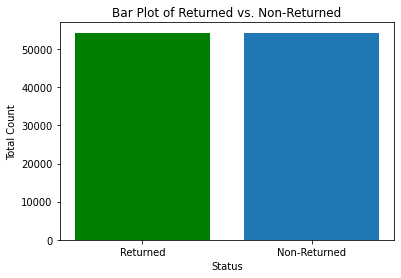

In [31]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', random_state=125) #This means that if the majority class had 1,000 examples and the minority class had 100, 
                                                             # this strategy would oversampling the minority class so that it has 1,000 examples.

Xo_train, yo_train = oversample.fit_resample(X_train, y_train)
print(Counter(yo_train))

counts2 = yo_train.value_counts()
plt.bar(counts2.index,
       counts2.values)

plt.gca().patches[1].set_facecolor('green')

plt.ylim(0,57000)

plt.xlabel('Status')
plt.ylabel('Total Count')
plt.title('Bar Plot of Returned vs. Non-Returned')
plt.xticks(counts2.index,
          ['Non-Returned', 'Returned'])
plt.show()

#### Undersampling

Undersampling takes pieces of the majority class to reduce the used portion of the majority class to have the same number of records as the minority class.

Counter({0: 9292, 1: 9292})


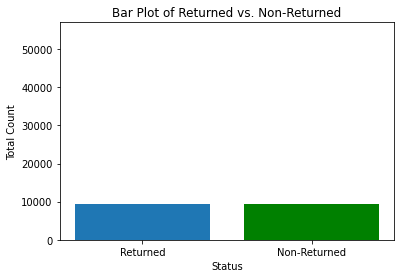

In [32]:
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=125)
# fit and apply the transform
Xu_train, yu_train = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(yu_train))


counts3 = yu_train.value_counts()
plt.bar(counts3.index,
       counts3.values)

plt.gca().patches[0].set_facecolor('green')

plt.ylim(0,57000)

plt.xlabel('Status')
plt.ylabel('Total Count')
plt.title('Bar Plot of Returned vs. Non-Returned')
plt.xticks(counts3.index,
          ['Non-Returned', 'Returned'])
plt.show()

#### SMOTE

SMOTE generates new records in the minority class to increase the number of records to equal the number in the majority class.

Counter({0: 54243, 1: 54243})


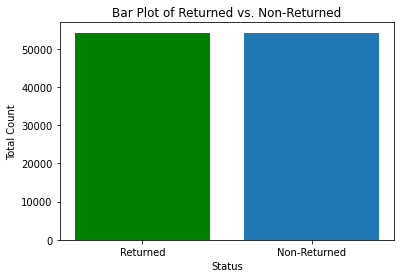

In [33]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
Xs_train, ys_train = oversample.fit_resample(X_train, y_train)

print(Counter(ys_train))

counts4 = ys_train.value_counts()
plt.bar(counts4.index,
       counts4.values)

plt.gca().patches[1].set_facecolor('green')

plt.xlabel('Status')
plt.ylabel('Total Count')
plt.title('Bar Plot of Returned vs. Non-Returned')
plt.xticks(counts4.index,
          ['Non-Returned', 'Returned'])
plt.show()

## Model 1: Logistic Regression

#### Using Oversampled Set

In [34]:
#try 2 fits for this model one for over, one for under
logrego = LogisticRegression(random_state=125) #max_iter=175) # remove warning
logrego.fit(Xo_train, yo_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=125)

In [35]:
logrego.score(Xo_train, yo_train) #train model score

0.5395074018767398

In [36]:
logrego.score(X_test, y_test) #unseen realistic data (bias)

0.3984135228292176

In [37]:
logrego.score(Xu_train, yu_train) #testing on undersampling set using the oversampling sets trained model

0.5388506241928541

In [38]:
logrego.score(X,y)

0.40236560662936466

#### Using Undersampled Set

In [39]:
logregu = LogisticRegression(random_state=125)
logregu.fit(Xu_train, yu_train)

LogisticRegression(random_state=125)

In [40]:
logrego.score(Xu_train, yu_train) #train model score

0.5388506241928541

In [41]:
logregu.score(X_test, y_test) #unseen realistic data (bias)

0.4007743519524057

In [42]:
logregu.score(Xo_train, yo_train) #testing on oversampling set using the undersampling sets trained model

0.5363457035930903

In [43]:
logregu.score(X, y)

0.4045966428217296

#### Using SMOTE

In [44]:
logregu = LogisticRegression(random_state=0)
logregu.fit(Xs_train, ys_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [45]:
logregu.score(Xs_train, ys_train) #train model score

0.7656656158398318

In [46]:
logregu.score(X_test, y_test) #unseen realistic data (bias)

0.741489211010907

### Grid Search
We decided to change the solver and C (penalty strength) hyperparameters. With how our baseline model of logistic regression was performing, we needed to edit highly impactful hyperparameters to change how the logistic regression model was learning. One step was to change the solver. The solver is the type of algorithm used for optimization. The thought behind changing the solver was to see if the model could find a different way optimize the data, then maybe it could give us better accuracy. In addition to the solver, the C hyperparameter was also changed for overfitting reasons. It controls the strength of regularization in which it could make the model either simple or complex.

In [47]:
logreg = LogisticRegression(random_state=125)
grid={"solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C":np.logspace(-3,3,7)}
search = GridSearchCV(logreg, grid, cv=10, scoring='accuracy')

#### Using Oversampled Set

In [48]:
search.fit(Xo_train, yo_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=125),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [49]:
search.best_score_ #accuary of best model

0.5383090971096667

In [50]:
search.best_params_ #params used to get best model

{'C': 0.1, 'solver': 'saga'}

In [51]:
search.best_estimator_

LogisticRegression(C=0.1, random_state=125, solver='saga')

In [52]:
logrego2 = LogisticRegression(C=0.1, solver='saga', random_state=125)

In [53]:
logrego2.fit(Xo_train, yo_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, random_state=125, solver='saga')

In [54]:
logrego2.score(Xo_train, yo_train)

0.5405029220360231

In [55]:
logrego2.score(X_test, y_test)

0.39883847207139145

In [56]:
logrego2.score(Xu_train, yu_train)

0.5404649160568231

In [57]:
logrego2.score(X, y)

0.4039828127582218

#### Using Undersampled Set

In [58]:
search.fit(Xu_train, yu_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=125),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [59]:
search.best_score_ #accuracy of best model

0.5331478201354826

In [60]:
search.best_params_ #parameters used to get the best model

{'C': 1.0, 'solver': 'newton-cg'}

Now we try using the best hyperparameter settings for the undersampled set

In [61]:
logregu2 = LogisticRegression(C=1.0, solver='newton-cg', random_state=125)
logregu2.fit(Xu_train, yu_train)
logregu2.score(Xu_train, yu_train)

0.5434244511407662

In [62]:
logregu2.score(X_test, y_test)

0.40256858208602864

In [63]:
logregu2.score(Xo_train, yo_train)

0.5367328503217005

In [64]:
logregu2.score(X, y)

0.40633189319356894

### Using SMOTE Sampling

In [65]:
search.fit(Xs_train, ys_train)

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\ARIKOHL\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=125),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [66]:
search.best_params_ #parameters used to get the best model

{'C': 100.0, 'solver': 'liblinear'}

In [67]:
logregu2 = LogisticRegression(C=100, solver='newton-cg', random_state=125)
logregu2.fit(Xs_train, ys_train)
logregu2.score(Xs_train, ys_train)

0.7728370480983722

In [68]:
logregu2.score(X_test, y_test) #unseen realistic data (bias)

0.75395438878134

Changing the hyperparameters made the oversampled set of training data have almost no change in accuracy rate (from .54 to .5405 for training and .3988 to .3988 for test). As for the under sample, there were only slight improvements (from .5389 to .5434 for the training and from .401 to .4026 for the test). For the SMOTE oversampling method, the change made the model slightly better for the training and the testing.

## Model 2: Random Forest

#### Using Oversampled Set

In [69]:
clfo = RandomForestClassifier(random_state=125)
clfo.fit(Xo_train, yo_train)

RandomForestClassifier(random_state=125)

In [70]:
clfo.score(Xo_train, yo_train) #trained model score

0.9585937355972199

In [71]:
clfo.score(X_test, y_test) #unseen data

0.7420558100004722

In [72]:
clfo.score(Xu_train, yu_train) #testing on undersampling set using the oversampling sets trained model

0.9557145931984503

In [73]:
clfo.score(X,y)

0.8847652100007083

Random Forest model trained using the oversampled set is better than Logistic regression

#### Using Undersampled Set

In [74]:
clfu = RandomForestClassifier(random_state=125)
clfu.fit(Xu_train, yu_train)

RandomForestClassifier(random_state=125)

In [75]:
clfu.score(Xu_train, yu_train) #trained model score

0.9616336633663366

In [76]:
clfu.score(X_test, y_test) #unseen data score

0.5149440483497805

In [77]:
clfu.score(Xo_train, yo_train) #testing on oversampling set using the undersampling sets trained model

0.7785428534557455

In [78]:
clfu.score(X,y)

0.6146563732086786

There is possible overfitting case here due to the testing scores being lower and the training scores being so good

#### Using SMOTE sampling

In [79]:
clfs = RandomForestClassifier(random_state=0)
clfs.fit(Xs_train, ys_train)
clfs.score(Xs_train, ys_train) #trained model score

0.9457625868775694

In [80]:
clfs.score(X_test, y_test) #unseen realistic data (bias)

0.7082487369564191

### Grid Search
The hyperparameters max_depth, and n_estimators help limit overfitting of a model. They both have a type of cutoff point wherein the model will stop training at where we set the cutoff point and then it stops the model from training too much which would cause overfitting. As we can see with our accuracy scores, the model tend to overfit in the training data so it seems best to edit these hyperparameters to try and get a better model.

In [81]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_depth': [10, 15, 20, 25]
}

In [82]:
clf = RandomForestClassifier(random_state=125)
grid_search = GridSearchCV(clf, param_grid=param_grid)

#### Using Oversampled Set

In [83]:
grid_search.fit(Xo_train, yo_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=25, n_estimators=150, random_state=125)


In [84]:
clf_grid = RandomForestClassifier(max_depth=25, n_estimators=150, random_state=125) #max_features= None, n_estimators=25
clf_grid.fit(Xo_train, yo_train) 
clf_grid.score(Xo_train, yo_train) #trained model score

0.9494128274616079

In [85]:
clf_grid.score(X_test, y_test) #unseen data score (bias)

0.7260021719627934

In [86]:
clf_grid.score(Xu_train, yu_train) #testing on undersampling set using the oversampling sets trained model

0.9457597933706414

In [87]:
clf_grid.score(X, y)

0.87143801496801

#### Using Undersampled Set

In [88]:
grid_search.fit(Xu_train, yu_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=125)


In [89]:
clf_grid = RandomForestClassifier(max_depth=10, n_estimators=150, random_state=125) #max_features= None, n_estimators=25
clf_grid.fit(Xu_train, yu_train) 
clf_grid.score(Xu_train, yu_train) #trained model score

0.62656048213517

In [90]:
clf_grid.score(X_test, y_test) #unseen data score

0.3744274989376269

In [91]:
clf_grid.score(Xo_train, yo_train) #testing on oversampling set using the undersampling sets trained model

0.5844072046162638

In [92]:
clf_grid.score(X, y)

0.3958849776896381

#### Using SMOTE sampling

In [93]:
grid_search.fit(Xs_train, ys_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=25, n_estimators=150, random_state=125)


In [94]:
clf_grid = RandomForestClassifier(max_depth=25, n_estimators=150, random_state=0)
clf_grid.fit(Xs_train, ys_train) 
clf_grid.score(Xs_train, ys_train) #trained model score

0.8912578581568129

In [95]:
clf_grid.score(X_test, y_test) #trained model score

0.6524859530667171

The hyperparameters found by grid search made the model performance worse on the unseen data. When using the over sampled set, the training accuracy went from .9586 to .9494 and the test accuracy went from .742 to .726. When using the under sampled set, the training accuracy went from .9616 to .6265 and the test accuracy went from .5149 to .3744. For the SMOTE oversampling, the same can be seen in which the model become worse when the new hyperparameters are applied.

## Final Model Picks

Due to how the scores were, using over sampling helps the model have more data to train on and the model that produced the best scores was the random forest model (with or without specific hyperparameters does not have a significant effect)

In [96]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
# Use oversampling
clf_grid = RandomForestClassifier(max_depth=25, n_estimators=150, random_state=125) #max_features= None, n_estimators=25
clf_grid.fit(Xo_train, yo_train) 
clf_grid.score(Xo_train, yo_train) #trained model score

0.9494128274616079

In [98]:
clf_grid.score(X_test, y_test) #unseen data

0.7260021719627934

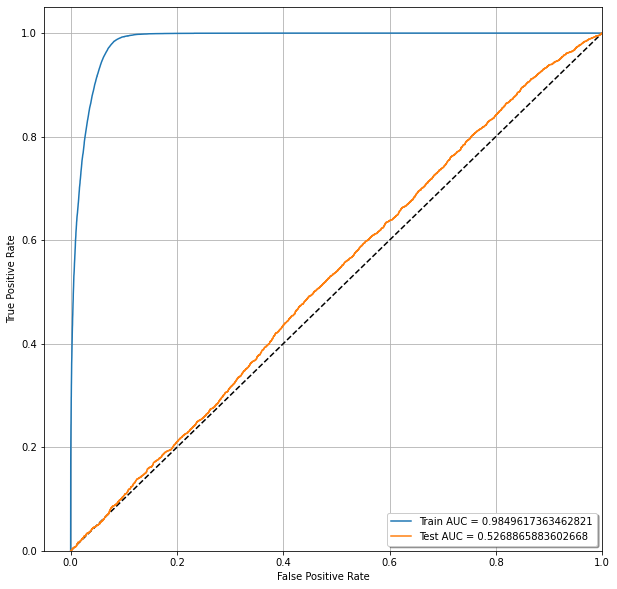

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = clf_grid.score(X_test,y_test)

# get roc/auc info
Y_score = clf_grid.predict_proba(Xo_train)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(yo_train, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

Yt_score = clf_grid.predict_proba(X_test)[:,1]
fprt = dict()
tprt = dict()
fprt, tprt, _ = roc_curve(y_test, Yt_score)

roc_auct = dict()
roc_auct = auc(fprt, tprt)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='Train AUC = {0}'.format(roc_auc))  
plt.plot(fprt, tprt, label='Test AUC = {0}'.format(roc_auct))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

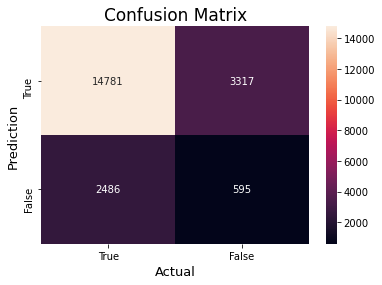

In [100]:
y_hat = clf_grid.predict(X_test)
cm = confusion_matrix(y_test, y_hat)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['True','False'],
            yticklabels=['True','False'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

#cm = confusion_matrix(y.argmax(axis=1), y_hat.argmax(axis=1)) 

In [101]:
from sklearn.metrics import classification_report
 
yt_pred = clf_grid.predict(X_test)
print(classification_report(y_test, yt_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     18098
           1       0.15      0.19      0.17      3081

    accuracy                           0.73     21179
   macro avg       0.50      0.50      0.50     21179
weighted avg       0.75      0.73      0.74     21179



In [102]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf_grid, X, y, cv = k_folds)

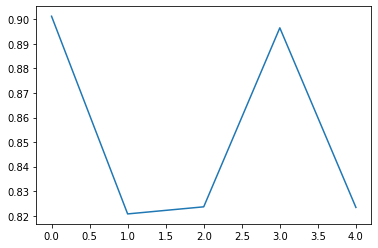

In [103]:
plt.plot(scores)

## Feature Importance

This is showing the coefficients of each of the columns/ features we have in our data set. It gives us information about how important the feature is to our target variable.

In [104]:
clf_grid.feature_importances_

array([4.92950017e-01, 5.08265060e-02, 2.07707555e-02, 1.74101114e-02,
       1.63632608e-02, 2.19336394e-02, 2.14410593e-02, 1.47311130e-02,
       4.61275707e-03, 7.00821278e-03, 6.33650246e-03, 1.01142253e-02,
       7.86391603e-03, 8.58974484e-03, 3.43448883e-03, 3.81244971e-03,
       9.05412720e-04, 1.99187416e-03, 4.41237819e-04, 5.92756723e-03,
       9.55603399e-04, 7.48900487e-03, 1.08157603e-02, 8.49526232e-03,
       4.40994522e-03, 2.92897994e-03, 5.20392464e-03, 2.76895976e-03,
       6.31835067e-03, 4.00786059e-03, 7.59590276e-03, 6.10387854e-03,
       1.12326261e-02, 3.01507408e-03, 3.84921076e-02, 2.16160167e-02,
       1.53083933e-03, 1.00298516e-02, 4.44938932e-03, 3.01575481e-03,
       5.03703375e-03, 2.46335964e-03, 2.09081833e-04, 2.57465086e-04,
       8.98333740e-04, 2.48642271e-05, 8.95191337e-04, 6.34274165e-04,
       4.47238308e-04, 2.06383549e-03, 9.12187709e-04, 1.21877180e-03,
       3.76593930e-04, 6.75455624e-03, 1.09625154e-04, 4.07119273e-04,
      

<Axes: >

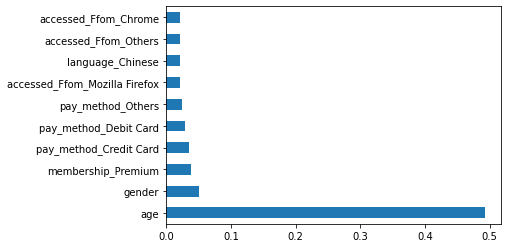

In [105]:
feat_importances = pd.Series(clf_grid.feature_importances_, index=Xo_train.columns)
feat_importances.nlargest(10).plot(kind='barh') #shows top nlargest important features

Age, gender, and the type of memebership seem to be the most important fearures that affect whether or not a customer returns a product or not. We should look into these more to find out informtaion how to use this data for our business scope

### Conclusion

In conclusion, our exploration into the ecommerce dataset had shed light on critical insights and areas of improvement. First, we showcased the impact of attributes such as age, membership type, language, and gender on the likelihood of returns. For us to enhance our findings, we recognize the need for richer reviews and additional data collection. Elevating the predictive power of our model can be achieved by using neural network tailored to our dataset and introducing more detailed information on the reasons for returns. The next steps involve gathering more diverse and detailed data, embracing customer feedback to inform marketing strategies, and refining the returns process to bolster customer satisfaction and, consequently, profitability. 

Given these next steps, having more data may allow us to predict whether or not an item is returned, in which that model could give insight on which features would be best to focus on that have the greatest impact on a returned item. The features that are chosen could be used for developing a marketing strategy against those features to be able to lessen that amount of returns. In addition to marketing strategies, when our model is able to predict whether an item is returned or not based on these features, we can use those predictions as a way for budgeting on a possibly monthly or quarterly basis.